# Movies clustering by plot

<p style="text-align: justify;">
    <br /> 
When I was a kid my two favourites movies were Bravehart and Gladiator, but now is Forrest Gump.
    <br /> 
<br /> 
I found this dataset on Datacamp uploaded by Anubhav Singh, which has the top 100 movies of all time with the plots from Wikipedia and IMDb. The idea is to find relations between movies based on the plot using NLP tools. I will try to find out why I liked those movies the most.
</p>

---

## 1. Extract and transform

In [1]:
import pandas as pd
df = pd.read_csv('datasets/movies.csv', index_col='rank')

print("Number of movies: %s " % (len(df)))
df.head()

Number of movies: 100 


,title,genre,wiki_plot,imdb_plot
rank,,,,
0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [2]:
# Combine the plots from Wikipedia and IMDb
df['plot'] = df['wiki_plot'].astype(str) + '\n' + df['imdb_plot'].astype(str)

# Drop the wiki_plot and imdb_plot columns
df = df.drop(['wiki_plot','imdb_plot'], axis=1)
df.head()

,title,genre,plot
rank,,,
0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit..."
1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ..."
2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the..."
3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight..."
4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...


---

## 2. Tokenization and stemming

In [3]:
import nltk
import re
from nltk.stem.snowball import SnowballStemmer

# Instantiate the stemmer for english
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    '''
    This function recieves a text and it tokenize it, then extracts 
    only the words and returns the stems of the words in the text.
    '''
    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stems = [stemmer.stem(word) for word in filtered_tokens]
    return stems

print("Input example: Today (May 19, 2016) is his only daughter's wedding.")
print('')
print('Output example: %s '%tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding."))

Input example: Today (May 19, 2016) is his only daughter's wedding.

Output example: ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed'] 


---

## 3. Vectorizing with TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

# Instantiate TfidfVectorizer object with stopwords and tokenizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem,
                                   ngram_range=(1,3))

# Fit and transform the tfidf_vectorizer with the plot
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in df["plot"]])

print(tfidf_matrix.shape)

(100, 564)


---

## 4. Clustering with K-Means

In [5]:
import numpy as np
from sklearn.cluster import KMeans

# Set seed for reproducibility
np.random.seed(5)

# Instantiate k-means with a 5 cluster division
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

# Add the cluster column to the DataFrame
df["cluster"] = km.labels_.tolist()

print('Clusters')
print(df['cluster'].value_counts())
df.head()

Clusters
2    35
1    21
3    20
0    17
4     7
Name: cluster, dtype: int64


,title,genre,plot,cluster
rank,,,,
0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...",2
1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...",3
2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",1
3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...",2
4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,3


---

## 5. Dendogram

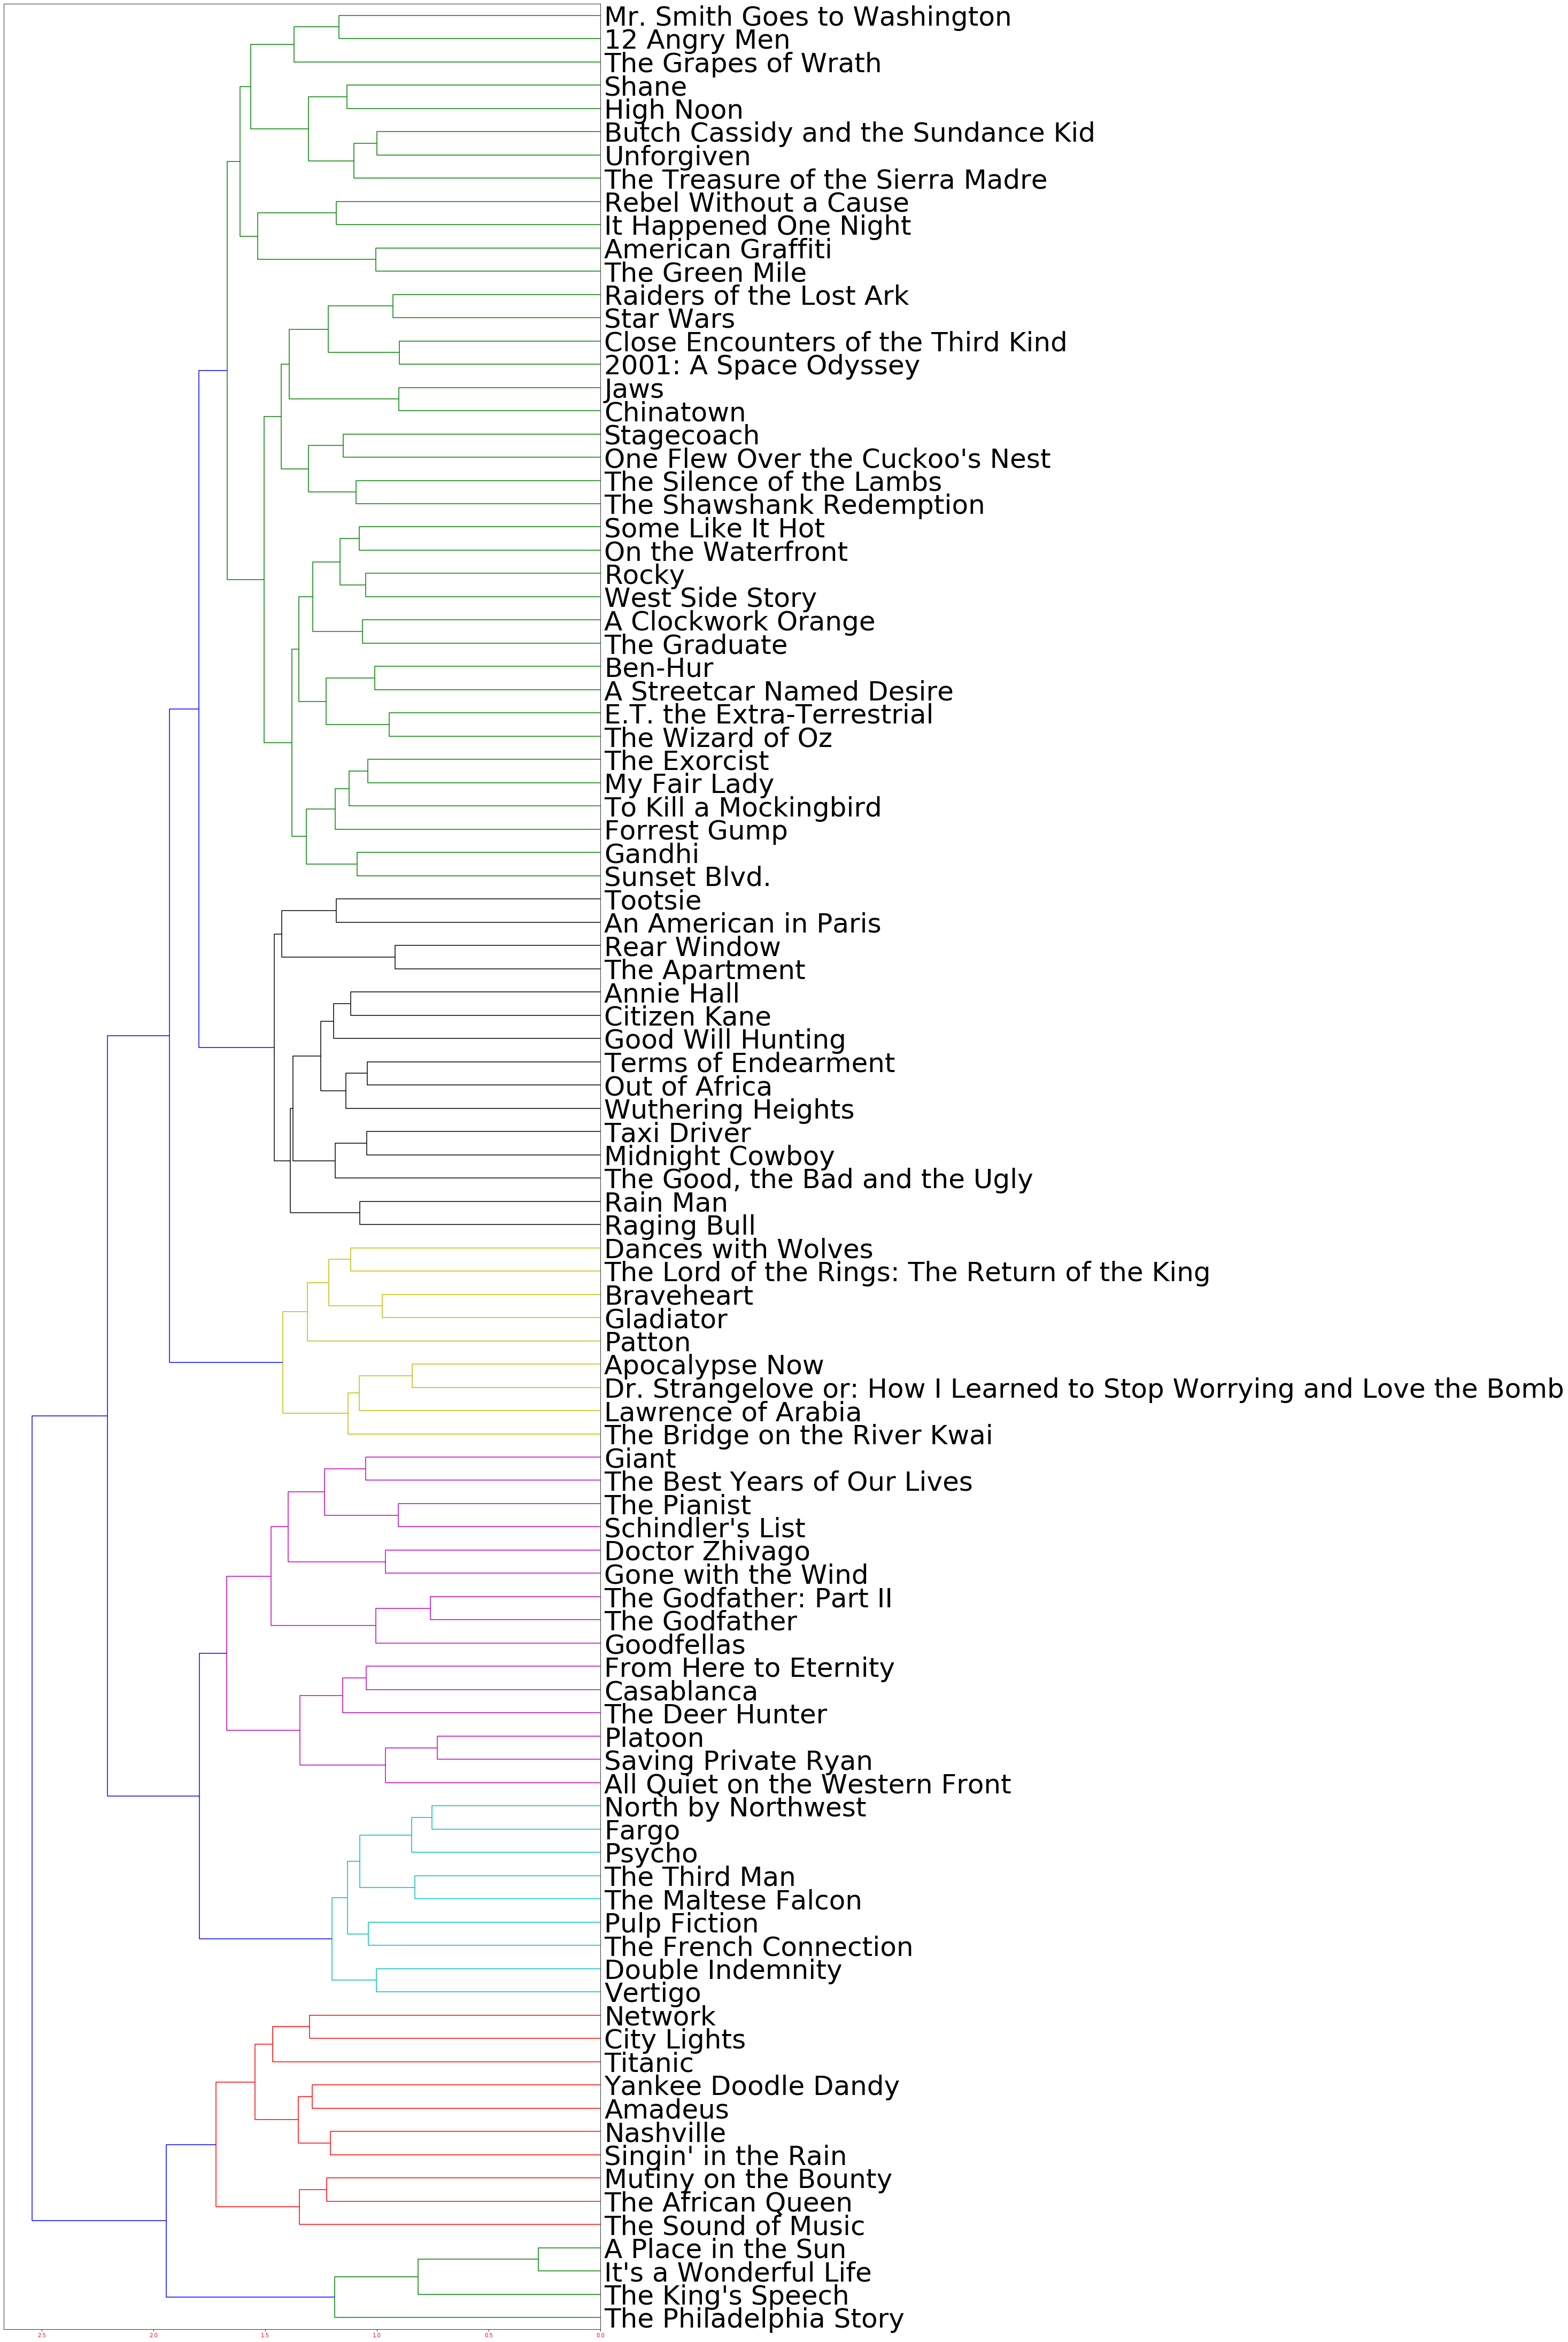

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings, orientation="left",
               labels=[x for x in df["title"]],
               leaf_font_size=50)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(20, 80)

# Show the plotted dendrogram
plt.show()

---

## 6. Conclusion

<p style="text-align: justify;">
    <br /> 
Bravehart's most similar movie is Gladiator, it can be seen at the yellow branch. That would explain why were they my favourite movies when I was a kid.
    <br /> 
<br /> 
On the other hand, Forrest Gump is a movie that doesen't have much similarities with others as seen on the green branch, maybe that is te reason why is my favourite movie now.
</p>

---